Let's install all require libraries

In [1]:
!pip install transformers
!pip install scikit-learn
!pip install xgboost
!pip install seaborn
!pip install matplotlib
!pip install nltk
!pip install joblib
!pip install pandas
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

Let's import all require libraries.


In [2]:
import numpy as np
import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from nltk.stem import WordNetLemmatizer
from umap import UMAP

**Let's put student id as a variable.**

In [3]:
student_id = 2320792 # Note this is an interger and you need to input your id

Let's set `seed` for all libraries like `torch`, `numpy` etc as my student id

In [4]:
# set same seeds for all libraries
#numpy seed
np.random.seed(student_id)

# Common Codes

In this section you will write all common codes, for examples


*   Data read
*   Command Line argument reading
*   Performance Matrics
*   Print Dataset Statistics
*   Saving model and output
*   Loading Model and output
*   etc




In [6]:
# Your Code(s)
PATH_AFTER_MYDRIVE = 'D:/git/Sentiment Analysis for Auto Reviews/'
MODEL_DIR = os.path.join('/content/gdrive/MyDrive/', PATH_AFTER_MYDRIVE, 'model')
DATA_DIR = os.path.join('/content/gdrive/MyDrive/',PATH_AFTER_MYDRIVE, 'data/21')

Model_Unsup = os.path.join(MODEL_DIR, str(student_id), 'Model_Unsup')
Model_Dis = os.path.join(MODEL_DIR, str(student_id), 'Model_Dis')

def create_path_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directories for path: {path}")
    else:
        print(f"Path already exists: {path}")

create_path_if_not_exists(Model_Unsup)
create_path_if_not_exists(Model_Dis)


Path already exists: /content/gdrive/MyDrive/CE807-24-SU/Assignment/model/2320792/Model_Unsup
Path already exists: /content/gdrive/MyDrive/CE807-24-SU/Assignment/model/2320792/Model_Dis


In [7]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Step 1: Data Reading
train_file =  os.path.join(DATA_DIR,'train.csv')
validation_file = os.path.join(DATA_DIR,'valid.csv')
test_file = os.path.join(DATA_DIR,'test.csv')

# Reading the data
train_data = pd.read_csv(train_file)
valid_data = pd.read_csv(validation_file)
test_data = pd.read_csv(test_file)


# Fill missing values with empty string
train_data['text'].fillna('', inplace=True)
valid_data['text'].fillna('', inplace=True)
test_data['text'].fillna('', inplace=True)

In [9]:
train_data.head()

,sentiment,text
0,negative,"Crappy knockoff. Didn't work for my vehicle, ..."
1,positive,"Does as it is advertised. For best results, l..."
2,positive,"Perfect fit, sealed well."
3,negative,"The light is white, but the light output is ho..."
4,positive,I have bought shades for my automobiles in the...


In [10]:
valid_data.head()

,sentiment,text
0,negative,"Received the multiple led bulb as pictured, it..."
1,negative,I think this is my first negative review. Sorr...
2,positive,The boys love it.
3,positive,"Hubby is happy with this, has it filled alread..."
4,negative,For what you get these are VASTLY over priced....


# Method Unsupervised Start




K means clustering is a unsupervised machine learning algorithm for grouping similar data points into distinct clusters.The method assigns each data point repeatedly to the closest centroid and updates the centroids based on the average of the points in every cluster after initializing a fixed number of centroids(k).This process is repeated until either the centroids do not change significantly.K-means is popular because of its ease of use and effectiveness in locating underlying patterns in data.

This project will use K-means to cluster automotive reviews depending on text features. Instead, we may group the reviews into clusters and then determine the emotion of each cluster by looking at its majority.The reason this approach was chosen is because it works well for exploratory data analysis and can reveal hidden structures in the data without the need for sample labels.I have referred all related information and code from this site https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html In addition, a dimension reduction method called UMAP (Uniform Manifold Approximation and Projection) maximizes a low-dimensional representation of high-dimensional data while maintaining its structure. It is helpful for exploratory data analysis and visualization as it is good at identifying patterns and clusters. For further details, see this thorough explanation https://umap-learn.readthedocs.io/en/latest/

## Training Unsupervised Method Code

First, we lemmatize the text data to make them easier to understand. Next, TF-IDF vectorization, dimensionality reduction using UMAP, and clustering using K-means to convert the text into numerical features.The trained pipeline is saved for future use. Both the training and validation datasets are used to assess the clustering quality using the Silhouette Score and calculating F1 score. ploting Confusion Matrix.

In [11]:
y_train = train_data['sentiment'].replace({'positive': 1, 'negative': 0})

y_valid = valid_data['sentiment'].replace({'positive': 1, 'negative': 0})


# Function for converting a numpy array from a DataFrame
lemmatizer = nltk.stem.WordNetLemmatizer()
def to_array(X):
    return X.toarray()

def lemmatize_text(text_input):
    """
    Lemmatize the text supplied and return it to its original form.
    Text_input (pd.Series or list of str) : The content to be lemmatized in text and It may be a list of strings or a pandas series.

     Returns: pd. list or series of str The input format was preserved in the lemmatized text data.

    Raises: ValueError: In the event that the input is not a list of strings or a pandas series.
    """

    # Check if the input is a DataFrame
    if isinstance(text_input, pd.Series):
        return text_input.apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
    # Check if the input is a list
    elif isinstance(text_input, list):
        return [" ".join([lemmatizer.lemmatize(word) for word in text.split()]) for text in text_input]
    else:
        raise ValueError("Input should be a pandas Series or a list of strings")



def train_unsup():


  # Creating the pipeline
  pipeline = Pipeline([
      ('lemmatizer', FunctionTransformer(lemmatize_text, validate=False)),
      ('vectorizer', TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 2))),
      ('to_array', FunctionTransformer(to_array, validate=False)),
      ('umap', UMAP(n_components=100, random_state=int(str(student_id)[-2:]))),
      ('kmeans', KMeans(n_clusters=2, random_state=int(str(student_id)[-2:]), n_init=30))
  ])
   # Fiting the pipeline
  pipeline.fit(train_data['text'])

  # Saving the pipeline
  joblib.dump(pipeline, Model_Unsup+'/unsupervised_model.pkl')



  # Validation
  # Silhouette score
  train_clusters = pipeline.predict(train_data['text'])
  validation_clusters = pipeline.predict(valid_data['text'])

  vectorizer = pipeline.named_steps['vectorizer']
  to_array_transformer = pipeline.named_steps['to_array']
  umap_transformer = pipeline.named_steps['umap']

  silhouette_avg = silhouette_score(umap_transformer.transform(to_array_transformer.transform(vectorizer.transform(train_data['text']))), train_clusters)
  # silhouette_avg = silhouette_score(to_array_transformer.transform(vectorizer.transform(train_data['text'])), train_clusters)
  print(f"Silhouette Score for Train Data: {silhouette_avg}")

  silhouette_avg = silhouette_score(umap_transformer.transform(to_array_transformer.transform(vectorizer.transform(valid_data['text']))), validation_clusters)
  # silhouette_avg = silhouette_score(to_array_transformer.transform(vectorizer.transform(valid_data['text'])), validation_clusters)
  print(f"Silhouette Score for Validation Data: {silhouette_avg}")

  clusters = pipeline.named_steps['kmeans'].labels_

  # Calculate the average_label for each cluster
  cluster_0_mean = np.mean(y_train[clusters == 0])
  cluster_1_mean = np.mean(y_train[clusters == 1])

  # Determine which cluster is positive(1) and which is negative(0)
  if cluster_0_mean > cluster_1_mean:
      cluster_to_sentiment = {0: "positive", 1: "negative"}
  else:
      cluster_to_sentiment = {0: "negative", 1: "positive"}

  joblib.dump(cluster_to_sentiment, Model_Unsup+'/cluster_to_sentiment.pkl')

  # Display the mapping
  for cluster_label, sentiment in cluster_to_sentiment.items():
      print(f"Cluster {cluster_label} is mostly {sentiment}")

  # Map the clusters to sentiments
  predicted_sentiments = np.array([1 if cluster_to_sentiment[cluster] == "positive" else 0 for cluster in clusters])
  accuracy = accuracy_score(y_train, predicted_sentiments)
  print(f"Clustering accuracy: {accuracy * 100:.2f}%")

  # Calculate the F1 score
  f1 = f1_score(y_train, predicted_sentiments)

  # Print F1 score
  print("F1 Score on Training Set:", f1)

    # Generate the confusion_matrix
  conf_matrix = confusion_matrix(y_train, predicted_sentiments)
  # Ploting the Confusion Matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  # Map the validation_clusters to sentiments
  validation_clusters = np.array([1 if cluster_to_sentiment[cluster] == "positive" else 0 for cluster in validation_clusters])
  # Calculating the F1 score
  f1 = f1_score(y_valid, validation_clusters)

  # Print F1 score
  print("F1 Score on Validation Set:", f1)

    # Generating the Confusion Matrix
  conf_matrix = confusion_matrix(y_valid, validation_clusters)
  # Plot the Confusion Matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

# train_unsup()


According to the silhouette scores computed for both training and validation sets, 0.8627 and 0.8719 respectively, K-means clustering model is efficient in providing clusters which are well separated as well as defined. Such consistency shows ability of the model to generalize on new unseen data effectively. Nevertheless, F1 scores for K-means are low; standing at 0.1677 on training set and 0.1481 on validation set revealing its limitations in sentiment classification aspect. This is confirmed by confusion matrices. In validation dataset there were 79 true negatives (TN), 1 false positive (FP), 344 false negatives (FN) while for the training dataset there existed 644 true negatives (TN), 7 false positives (FP) out of 2752 false negative (FN) and 278 true positives (TP). These results reveal that many positive reviews are misclassified as negative thus indicating that model faces challenges in distinguishing sentiments effectively while performing such task correctly within some instances such as shown by different scores.K-means low F1 scores arise mainly from its unsupervised nature; it clusters the data based on similarity of features without predefined sentiment labels leading to large classifications errors.

## Testing Method Unsupervised Code


`test_unsup()` is a function that checks if there is already existing a pre-trained unsupervised model for sentiment classification. The new model is trained if the model is not found. The function creates sentiment labels for the test data based on predicting sentiment clusters and converting them into positive or negative ones after loading the model. In order to assess cluster quality, it computes silhouette score and saves new results in CSV format. Finally, it forecasts sentiment for a set of new sample texts to demonstrate the algorithm's performance.

In [12]:
def test_unsup():
  if  not os.path.exists(Model_Unsup+'/unsupervised_model.pkl'):
    print("Model doest not exist in the directory: ", Model_Unsup+'/unsupervised_model.pkl',"\nTraining the model first")
    train_unsup()

  print("Starting the model testing process")
  # Load the pipeline
  loaded_pipeline = joblib.load(Model_Unsup+'/unsupervised_model.pkl')
  cluster_to_sentiment = joblib.load(Model_Unsup+'/cluster_to_sentiment.pkl')

  # Predict_clusters for the test_data
  test_clusters = loaded_pipeline.predict(test_data['text'])

  # Map the test_clusters to sentiments
  test_clusters = np.array([1 if cluster_to_sentiment[cluster] == "positive" else 0 for cluster in test_clusters])

  # Save the output to a .csv file
  test_data['out_label_model_unsup'] = test_clusters
  test_data.to_csv(test_file, index=False)
  print(f"Output saved to {test_file}")


  vectorizer = loaded_pipeline.named_steps['vectorizer']
  to_array_transformer = loaded_pipeline.named_steps['to_array']
  umap_transformer = loaded_pipeline.named_steps['umap']

  silhouette_avg = silhouette_score(umap_transformer.transform(to_array_transformer.transform(vectorizer.transform(test_data['text']))), test_clusters)
  print(f"Silhouette Score for Test Data: {silhouette_avg}")

### predicted: pos neg pos pos neg
### truth: neg pos  pos pos neg
  # Example of classifying new data
  new_texts = [
      "Not good",
      "Hubby is happy with this, has it filled already.  Second Pit Posse cabinet purchased and very pleased.",
      "Worked and works great.",
      "It works well, good product",
      "You live and you learn . . .<br /><br />I purchased this product because I would need it but I didn't need it immediately so it sat in the tool drawer until I did.  That was my mistake.  When I finally did go to use it, it leaked all over.  First I tightened all the fittings and then I taped all the treads and tightened everything up.  The unit still leaked so I contacted the manufacturer asking about a new hose.  It's been almost two weeks and no answer.  Obviously they have better things to do than to help customers with defective products.<br /><br />The lesson is clear: test the product when you get it because you can then return it.  Now I've got to see if I can find some fittings that will allow me to fashion my own hose so I won't lose my entire investment.<br /><br />I will never darken this company's doorstep again.<br /><br />UPDATE: A couple of weeks ago, I got an e-mail from the company and they sent me two replacement hoses.  Better late than never.  Unfortunately neither of them will hold on to the tire valve (they are the push-on clip type).  When I try to inflate, they just blow off.  Even when I hold them in place they seem to leak.  In 20 minutes of trying with these hoses, I didn't manage to add one pound of air to the tire.<br /><br />UPDATE as of 18-Mar-2016: I tried spraying silicone into the chuck to see if the seal was just too hard to make a proper seal.  Epic fail.  This product is never going to work.  Sadly, they have gone into the trash can because that's the most appropriate place for them."


  ]
  predicted_labels = loaded_pipeline.predict(new_texts)
  #Maping the clusters to sentiments
  predicted_labels = np.array([1 if cluster_to_sentiment[cluster] == "positive" else 0 for cluster in predicted_labels])
  print(f"Predicted Labels: {predicted_labels}")



# test_unsup()

The output shows the sentiment predictions made by the K-means clustering model. This highlights the model's ability to identify positive and negative sentiments, but it's shows some misclassifications. It shows the first example, "Not good" predicted as positive but actually this negative, and the same for the second example, "Hubby is happy with this, has it filled already. Second Pit Posse cabinet purchased and very pleased."This is positive, but it shows negative and other examples in that one of the examples is a lengthy negative review model predicted to be correct.




## Method Unsupervised End


# Method Discriminative Start
The discriminative method of machine learning techniques gives various algorithms for various tasks. Support vector machines (SVM) are one such model that we might choose because they perform well in high-dimensional spaces and are robust to overfitting, especially when working with small numbers of samples.For large and complex data sets, better performance can be achieved with models like Gradient Boosting Machines(GBM) and their advanced versions, of these same type of model such as XGBoost.

 Gradient Boosting Machines (GBM) fit a decision tree to minimize the loss function and correct errors of previous trees in the ensemble thereby learning complex patterns within data and GBM gives High accuracy and flexibility.Extreme Gradient Boosting, or XGBoost, is an improved form of GBM that combines parallel processing, regularization techniques, and other improvements to make it faster, more effective, and popular in competitions and real-world situations because of its excellent scalability and performance.
For further details, see this site https://xgboost.readthedocs.io/en/stable/install.html .


In [13]:
# Assuming 'text' is the column containing text data and 'label' is the target variable
X_train = train_data['text']
y_train = train_data['sentiment'].replace({'positive': 1, 'negative': 0})

X_valid = valid_data['text']
y_valid = valid_data['sentiment'].replace({'positive': 1, 'negative': 0})

X_test = test_data['text']

## Training Method Discriminative Code


In this code, we have developed a text categorization system using a Machine Learning approach by combining Natural Language Processing techniques. We preprocess the standardize the text by lemmatizing it and then convert the text into numerical characteristics using TF-IDF. We then create a pipeline to combine all these processes with an XGBoost model in order to predict binary outcomes. We will finally make use of a dataset to train the pipeline and evaluate its performance by computing the accuracy, along with the F1 score, which accounts for the model's balance between recall and precision.

In [14]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text_input):
    '''
    Input: text_input (Pandas Series Object or List)

    Process: Uses sci-kit learn lemmatizer to lemmatize the text in the input.

    Output: Pandas Series or List of strings with lemmatized text.

    '''
    # Checking if the input is a DataFrame and lematizes the text
    if isinstance(text_input, pd.Series):
        return text_input.apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

    # Check if the input is a list and then lematizes the text
    elif isinstance(text_input, list):
        return [" ".join([lemmatizer.lemmatize(word) for word in text.split()]) for text in text_input]
    else:
        raise ValueError("Input should be a pandas Series or a list of strings")



def train_dis():
  # lemmatizer = nltk.stem.WordNetLemmatizer()

  #Pipeline Creation
  pipeline = Pipeline([
      ('lemmatizer', FunctionTransformer(lemmatize_text, validate=False)),
      ('tfidf', TfidfVectorizer(stop_words='english')),
      ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',reg_lambda = 0.2))
  ])

  #Training the Pipeline
  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_train)
  accuracy = accuracy_score(y_train, y_pred)
  print(f"Accuracy on Training Set: {accuracy:.2f}")

  # Calculating the F1 score
  f1 = f1_score(y_train, y_pred)

  # Print F1 score
  print("F1 Score on Training Set:", f1)

    # Creating the confusion matrix
  conf_matrix = confusion_matrix(y_train, y_pred)




  # Plot the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

   # Saving the Model
  joblib.dump(pipeline, Model_Dis+'/discriminative_model.pkl')


  # Validation
  y_pred = pipeline.predict(X_valid)
  accuracy = accuracy_score(y_valid, y_pred)
  print(f"Accuracy on Validation Set: {accuracy:.2f}")
  # Calculating the F1 score
  f1 = f1_score(y_valid, y_pred)
  # Print F1 score
  print("F1 Score on Validation Set:", f1)


  # Creating the confusion matrix
  conf_matrix = confusion_matrix(y_valid, y_pred)

  # Plot the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()



# train_dis()



The machine learning pipeline, based on an XGBoostClassifier for sentiment prediction, demonstrates very good performance; the training set has proven to be of high accuracy of 0.96 and a high F1 score of 0.979, which successfully balances the precision and recall. Confusion matrix shows that the model has identified most of the negative (524) and positive (3027) cases correctly with few incidences of false negatives (3) and false positive (127). With an accuracy of 0.88 and an F1 score of 0.928 on the validation set, the model demonstrated robust performance, correctly identifying 360 positive and 38 negative events while minimizing false positives (42) and false negatives (14) in the process. These results suggest that the model has good generalization power and is robust and reliable for real-world applications, showing a balance between accuracy and recall.


## Testing Method Discriminative Code


First we create `test_dis()`function and using this function, the discriminative sentiment classification model is tested.It initially trains the model if it doesn't find a pre-trained model in the specified directory.This function loads the pre-trained model, saves the results to a csv file, and predicts sentiment labels for the test data.Moreover, it predicts sentiment labels for a collection of example texts, whether the text is positive or negative.



In [15]:
def test_dis():
  if  not os.path.exists(Model_Dis+'/discriminative_model.pkl'):
    print("Model doest not exist in the directory: ", Model_Dis+'/discriminative_model.pkl',"\nTraining the model first")
    train_dis()

  # Load the pipeline
  loaded_pipeline = joblib.load(Model_Dis+'/discriminative_model.pkl')

  # Generating predictions on the test_data
  test_predictions = loaded_pipeline.predict(test_data['text'])

  test_data['out_label_model_dis'] = test_predictions
  test_data.to_csv(test_file, index=False)
  print(f"Output saved to {test_file}")

  # Example of classifying new_texts
  new_texts = [
      "Not good",
      "Hubby is happy with this, has it filled already.  Second Pit Posse cabinet purchased and very pleased.",
      "Worked and works great.",
      "It works well, good product",
      "You live and you learn . . .<br /><br />I purchased this product because I would need it but I didn't need it immediately so it sat in the tool drawer until I did.  That was my mistake.  When I finally did go to use it, it leaked all over.  First I tightened all the fittings and then I taped all the treads and tightened everything up.  The unit still leaked so I contacted the manufacturer asking about a new hose.  It's been almost two weeks and no answer.  Obviously they have better things to do than to help customers with defective products.<br /><br />The lesson is clear: test the product when you get it because you can then return it.  Now I've got to see if I can find some fittings that will allow me to fashion my own hose so I won't lose my entire investment.<br /><br />I will never darken this company's doorstep again.<br /><br />UPDATE: A couple of weeks ago, I got an e-mail from the company and they sent me two replacement hoses.  Better late than never.  Unfortunately neither of them will hold on to the tire valve (they are the push-on clip type).  When I try to inflate, they just blow off.  Even when I hold them in place they seem to leak.  In 20 minutes of trying with these hoses, I didn't manage to add one pound of air to the tire.<br /><br />UPDATE as of 18-Mar-2016: I tried spraying silicone into the chuck to see if the seal was just too hard to make a proper seal.  Epic fail.  This product is never going to work.  Sadly, they have gone into the trash can because that's the most appropriate place for them."

  ]
  predicted_labels = loaded_pipeline.predict(new_texts)
  print(f"Predicted Labels: {predicted_labels}")


# test_dis()

This 'test_dis()' function output shows that the discriminative model predicted the sentiment labels as [1, 1, 1, 1, 0].it correctly identified the positive sentiment in four examples and the negative sentiment in one lengthy negative review, it misclassified the first example "Not good" as positive,but actually this is negative.Despite this error, the XGBoost model shows superior performance as compared to the K-means clustering model in accurately classifying sentiments in varied textual data.

## Discriminative Method  End


Please choose an option:
1. Train Model Unsupervised
2. Test Model Unsupervised
3. Train Model Discriminative
4. Test Model Discriminative
Enter the number corresponding to your choice: 1


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Silhouette Score for Train Data: 0.8171215057373047
Silhouette Score for Validation Data: 0.8185583353042603
Cluster 0 is mostly positive
Cluster 1 is mostly negative
Clustering accuracy: 25.05%
F1 Score on Training Set: 0.16772247360482653


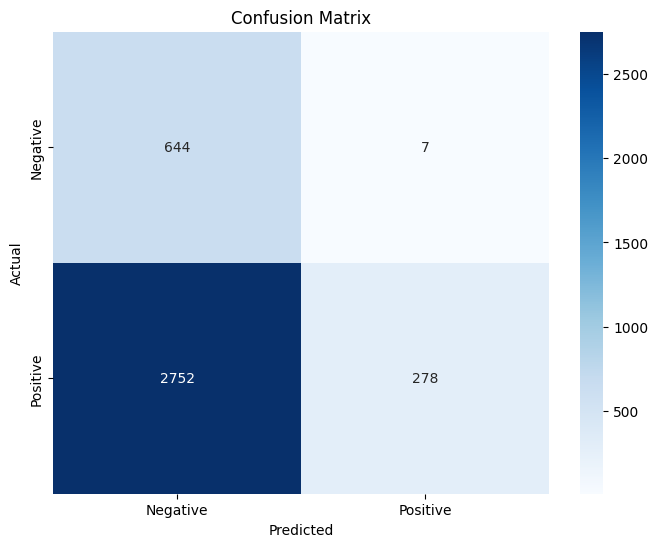

F1 Score on Validation Set: 0.14814814814814814


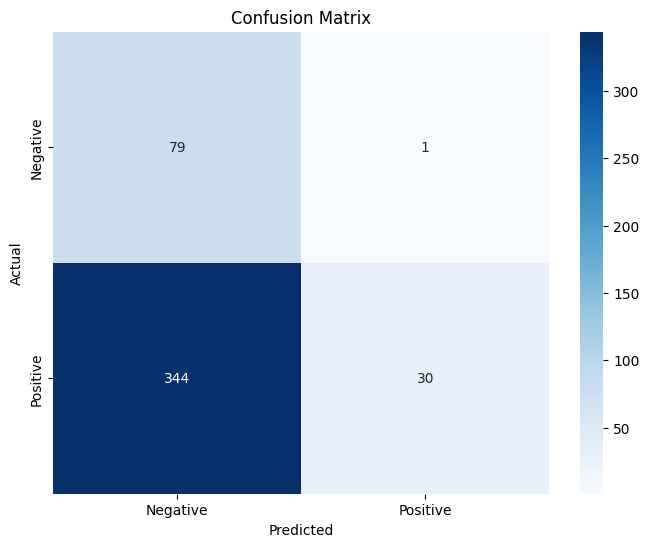

In [17]:
def main():
    print("Please choose an option:")
    print("1. Train Model Unsupervised")
    print("2. Test Model Unsupervised")
    print("3. Train Model Discriminative")
    print("4. Test Model Discriminative")

    option = input("Enter the number corresponding to your choice: ")

    if option == '1':
        train_unsup()
    elif option == '2':
        test_unsup()
    elif option == '3':
        train_dis()
    elif option == '4':
        test_dis()
    else:
        print("Invalid option. Please enter a number between 1 and 4.")

if __name__ == "__main__":
    main()

## References

sklearn.feature_extraction -  https://scikit-learn.org/stable/api/sklearn.feature_extraction.html

UMAP -  https://www.kaggle.com/code/bsagredo/mall-customer-segmentation-with-umap-kmeans and https://umap-learn.readthedocs.io/en/latest/

NLTK Sentiment- https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

XGBoost - https://forecastegy.com/posts/xgboost-binary-classification-python/ and https://xgboost.readthedocs.io/en/stable/install.html .

TF-IDF in Sentiment - https://www.tutorialspoint.com/tf-idf-in-sentiment-analysis
